# This notebook is used to carry out the MSM analysis of myosin with either ATP (ADP.Pi) to dATP (dADP.Pi) bound
This notebook was created by Marcus Hock in order to carry out construction, validation and analysis of prepowerstroke myosin bound to either ADP.Pi or dADP.Pi. The end goal of the analysis is to identify distinct conformations or metastable states that could be used in Brownian dynamics simulations. 

The process follows the general workflow: 
1. Trajectory analysis and featurization 
2. Dimmensionaility reduction using time-lagged independent component analysis (tICA)
3. Clustering and MSM construction including implied timescale analysis 
4. Coarse-graining and additional MSM validation 
5. Sampling from constructed states to be used in Brownian dynamics simulations

This notebook relies heavily on PyEmma and MDtraj as well as other traditional python packages. (http://www.emma-project.org/latest/ and https://www.mdtraj.org/1.9.8.dev0/index.html)

## Importing Necessary Modules and setting plotting settings
The `MSM_environment.yml` contains all of the packages that are installed when carrying out this analysis and can be used to create a replicate environment. 

In [60]:
# Import modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pyemma
import mdtraj as md
import seaborn as sns
from time import time
import pickle
import datetime
import os
import matplotlib as mpl
from tqdm import tqdm

# Define plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.grid']
plt.rcdefaults() 


## Loading in ADP and dADP myosin trajectory datasets
Note: Please specify the location of the trajectories using the `trajectory_path` variable. The full trajectories can be obtained via Dryad or by requesting access from the corresponding author Andrew McCulloch (amcculloch@ucsd.edu). 

Alternatively, these cells can be skipped, and the pickled data of the feature measurements can be loaded in the following section **Feature Construction**

In [3]:
# Set trajectory path
trajectory_path = '/crucial/trajectories/myosin/1qvi/'

In [4]:
# Define location for ADP myosin topology file 
adp_top = trajectory_path + '1qvi_adp_strip.prmtop'

# Define location for ADP myosin trajectory files 
adp_traj_files = [trajectory_path + '1qvi_adp_1_2us_10ps.nc', 
        trajectory_path + '1qvi_adp_2_2us_10ps.nc', 
        trajectory_path + '1qvi_adp_3_2us_10ps.nc']

In [6]:
# Define location for dADP myosin topology file 
dadp_top = trajectory_path + '1qvi_dadp_strip.prmtop'

# Define location for dADP myosin trajectory files 
dadp_traj_files = [trajectory_path + '1qvi_dadp_1_2us_10ps.nc', 
        trajectory_path + '1qvi_dadp_2_2us_10ps.nc', 
        trajectory_path + '1qvi_dadp_3_2us_10ps.nc']

In [7]:
# Create PyEmma feature instance for ADP myosin 
feature_loops_adp = pyemma.coordinates.featurizer(adp_top)

### Define specific features based on loops and residue center of masses
### Note atom seletion uses 0 based indices

# Get center of mass of tip of CM loop 
CM_tip = feature_loops_adp.select('resid 404 to 406')
# Get center of mass of base of CM loop
CM_base = feature_loops_adp.select('name CA and resid 413 400')


# Get center of mass of tip of loop 4
loop_4_tip = feature_loops_adp.select('resid 366 to 368')
# Get center of mass of base of loop 4
loop_4_base = feature_loops_adp.select('name CA and resid 361 374')

# Get center of mass of all of loop 2
loop_2_all = feature_loops_adp.select('resid 622 to 644')
# Get center of mass of tip of loop 2
loop_2_tip = feature_loops_adp.select('resid 630 to 633')

# Get center of mass of strut 
strut_COM = feature_loops_adp.select('name CA and resid 597 to 602')

# Define distaces to measure between for the cleft 
cleft_1 = feature_loops_adp.select('name CA and resid 370 540')
cleft_2 = feature_loops_adp.select('name CA and resid 405 540')

feature_loops_adp.add_group_COM([CM_tip, CM_base, loop_4_tip, loop_4_base, loop_2_all, loop_2_tip, strut_COM])

feature_loops_adp.add_distances([cleft_1,cleft_2])



In [8]:
# Create PyEmma feature instance for dADP myosin
feature_loops_dadp = pyemma.coordinates.featurizer(dadp_top)

### Define specific features based on loops and residue center of masses
### Note atom seletion uses 0 based indices

# Get center of mass of tip of CM loop 
CM_tip = feature_loops_dadp.select('resid 404 to 406')
# Get center of mass of base of CM loop
CM_base = feature_loops_dadp.select('name CA and resid 413 400')


# Get center of mass of tip of loop 4
loop_4_tip = feature_loops_dadp.select('resid 366 to 368')
# Get center of mass of base of loop 4
loop_4_base = feature_loops_dadp.select('name CA and resid 361 374')

# Get center of mass of all of loop 2
loop_2_all = feature_loops_dadp.select('resid 622 to 644')
# Get center of mass of tip of loop 2
loop_2_tip = feature_loops_dadp.select('resid 630 to 633')

# Get center of mass of strut 
strut_COM = feature_loops_dadp.select('name CA and resid 597 to 602')

# Define distaces to measure between for the cleft 
cleft_1 = feature_loops_dadp.select('name CA and resid 370 540')
cleft_2 = feature_loops_dadp.select('name CA and resid 405 540')

feature_loops_dadp.add_group_COM([CM_tip, CM_base, loop_4_tip, loop_4_base, loop_2_all, loop_2_tip, strut_COM])

feature_loops_dadp.add_distances([cleft_1,cleft_2])



### Use pyemma source loading to read trajectories and feature measurements 

In [10]:
# Create "source" instance to prepare to read in the data
data_adp = pyemma.coordinates.source(adp_traj_files,
                                     features=feature_loops_adp,
                                     chunksize = 5000)

# Get the COM measurements from the source reader
# Takes a while generally to load through all data. 
# Also be aware of computer memory limitations 
Loop_COMs_output = data_adp.get_output()

Obtaining file info:   0%|                                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                                  | 0/120 [00:00<?, ?it/s]

In [12]:
# Optional, recommend saving the featureset 
# This allows the feature loading step to be skipped in the future
f = open('msm_datafiles/all_loop_COMs_adp.pkl','wb')
pickle.dump(Loop_COMs_output, f)
f.close()

In [13]:
# Create "source" instance to prepare to read in the data
data_dadp = pyemma.coordinates.source(dadp_traj_files,
                                      features=feature_loops_dadp,
                                      chunksize = 5000)

# Get the COM measurements from the source reader
# Takes a while generally to load through all data. 
# Also be aware of computer memory limitations 
Loop_COMs_output = data_dadp.get_output()

Obtaining file info:   0%|                                                | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|                                  | 0/120 [00:00<?, ?it/s]

In [15]:
# # Optional, recommend saving the featureset
# This allows the feature loading step to be skipped in the future
f = open('msm_datafiles/all_loop_COMs_dadp.pkl','wb')
pickle.dump(Loop_COMs_output, f)
f.close()

## Feature Constrution 
Start here to load in precalulated measurements (either calculated above, or downloaded from GitHub). 

In [14]:
# Test to ensure the current working directory matches the saving locations
pwd = os.getcwd()
print(pwd)

/crucial/dATP_multiscale_modeling/molecular_analysis


In [17]:
# Load in the pickled data from the previous section 
# Note, this is redundant if the previous data was loaded/ran already
f = open('msm_datafiles/all_loop_COMs_adp.pkl','rb')
ADP_COMS_output = pickle.load(f)
f.close()

f = open('msm_datafiles/all_loop_COMs_dadp.pkl','rb')
dADP_COMS_output = pickle.load(f)
f.close()

In [18]:
# Create a concatendated list of all feature meaurements 
# Including both ADP and dADP data 
ADP_dADP_COMs_output = [ADP_COMS_output[0],
                        ADP_COMS_output[1],
                        ADP_COMS_output[2],
                        dADP_COMS_output[0],
                        dADP_COMS_output[1],
                        dADP_COMS_output[2]]

In [19]:
### Calculate the distance between the selected center's of masses 

# Define empty list to populate
inter_region_distances = []

# Cycle through meaurements from all 6 trajectories
for data_chunk in ADP_dADP_COMs_output:
    new_chunk = []
    # Cycle through and calculate the distance between the combinations of 
    # Different region's center of masses
    for i in range(7):
        for j in range(i+1,7):
            x = np.linalg.norm(data_chunk[:,i*3:i*3+3] - data_chunk[:,j*3:j*3+3],
                               axis = 1)
            new_chunk.append(x)
            
    # Cleft measurement appending (not used in COM distance calculations)
    new_chunk.append(data_chunk[:,21])
    new_chunk.append(data_chunk[:,22])
    # Reshape numpy array to fit needs to PyEmma
    new_chunk = np.array(new_chunk).reshape(-1,200000).T
    # Append to list
    inter_region_distances.append(new_chunk)

In [20]:
### Construct list of names for combinations of measurements used in feature 
### creation 

name_list = ['CM_tip', 'CM_base', 'loop_4_tip', 'loop_4_base', 'loop_2_all', 'loop_2_tip', 'strut_COM']
measure_name_list = []
for i in range(7):
    for j in range(i+1,7):
        measure_name_list.append('COM {} - {}'.format(name_list[i],name_list[j]))
        
# Append cleft names 
measure_name_list.append('DIST: GLN371 CA - LYS541 CA')
measure_name_list.append('DIST: GLY406 CA - LYS541 CA')

for name in measure_name_list:
    print(name)

COM CM_tip - CM_base
COM CM_tip - loop_4_tip
COM CM_tip - loop_4_base
COM CM_tip - loop_2_all
COM CM_tip - loop_2_tip
COM CM_tip - strut_COM
COM CM_base - loop_4_tip
COM CM_base - loop_4_base
COM CM_base - loop_2_all
COM CM_base - loop_2_tip
COM CM_base - strut_COM
COM loop_4_tip - loop_4_base
COM loop_4_tip - loop_2_all
COM loop_4_tip - loop_2_tip
COM loop_4_tip - strut_COM
COM loop_4_base - loop_2_all
COM loop_4_base - loop_2_tip
COM loop_4_base - strut_COM
COM loop_2_all - loop_2_tip
COM loop_2_all - strut_COM
COM loop_2_tip - strut_COM
DIST: GLN371 CA - LYS541 CA
DIST: GLY406 CA - LYS541 CA


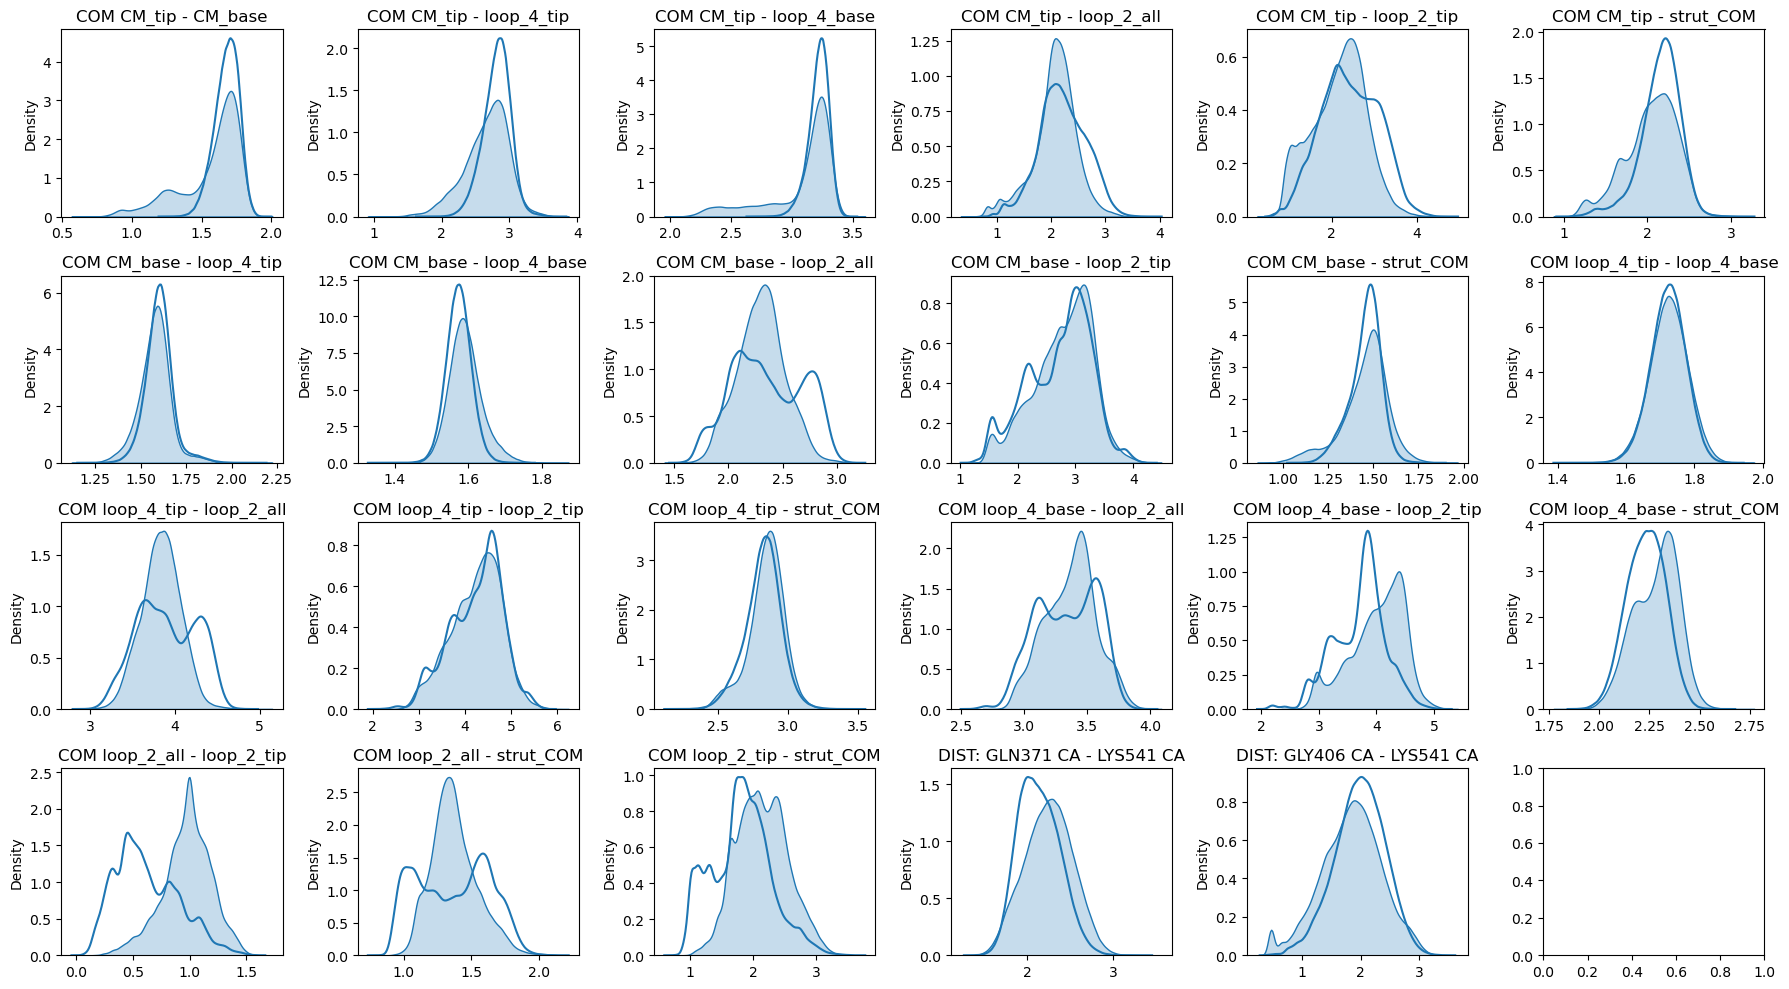

In [21]:
# Visualize the feature distributions for ADP and dADP 
# Note: Slow visualization 

fig, ax = plt.subplots(4,6,figsize = (18,10))
for i in range(23):
    x = i % 6 
    y = i // 6
    ax_sel = ax[y,x]
    sns.kdeplot(np.concatenate(np.array(inter_region_distances)[0:3])[:,i], ax = ax_sel)
    sns.kdeplot(np.concatenate(np.array(inter_region_distances)[3:6])[:,i], ax = ax_sel, fill = True)
    ax_sel.set_title(measure_name_list[i])
    
    
plt.tight_layout()
plt.show()

In [23]:
# Carry out tICA anlysis in 2 D

n_dim = 2
tica = pyemma.coordinates.tica(inter_region_distances, dim = n_dim, lag = 20)
tica_output = tica.transform(inter_region_distances)


calculate covariances:   0%|                                              | 0/6 [00:00<?, ?it/s]

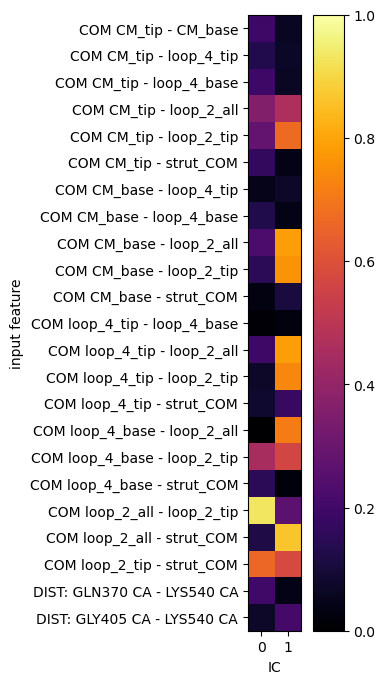

In [11]:
# tICA Feature Correlation 
fig, ax = plt.subplots(figsize=(3, 8))
i = ax.imshow(np.abs(tica.feature_TIC_correlation), cmap='inferno', vmax = 1, vmin = 0)

ax.set_xticks(range(tica.dimension()))
ax.set_xlabel('IC')

ax.set_yticks(np.arange(len(measure_name_list)))
ax.set_yticklabels(measure_name_list)
ax.set_ylabel('input feature')

fig.colorbar(i)

In [24]:
formatted_list_name = ['Dist: CM Loop tip - CM Loop base',
 'Dist: CM Loop tip - Loop 4 tip',
 'Dist: CM Loop tip - Loop 4 base',
 'Dist: CM Loop tip - Loop 2 all',
 'Dist: CM Loop tip - Loop 2 tip',
 'Dist: CM Loop tip - Strut COM',
 'Dist: CM Loop base - Loop 4 tip',
 'Dist: CM Loop base - Loop 4 base',
 'Dist: CM Loop base - Loop 2 all',
 'Dist: CM Loop base - Loop 2 tip',
 'Dist: CM Loop base - Strut COM',
 'Dist: Loop 4 tip - Loop 4 base',
 'Dist: Loop 4 tip - Loop 2 all',
 'Dist: Loop 4 tip - Loop 2 tip',
 'Dist: Loop 4 tip - Strut COM',
 'Dist: Loop 4 base - Loop 2 all',
 'Dist: Loop 4 base - Loop 2 tip',
 'Dist: Loop 4 base - Strut COM',
 'Dist: Loop 2 all - Loop 2 tip',
 'Dist: Loop 2 all - Strut COM',
 'Dist: Loop 2 tip - Strut COM',
 'Dist: GLN370 CA - LYS540 CA',
 'Dist: GLY405 CA - LYS540 CA']

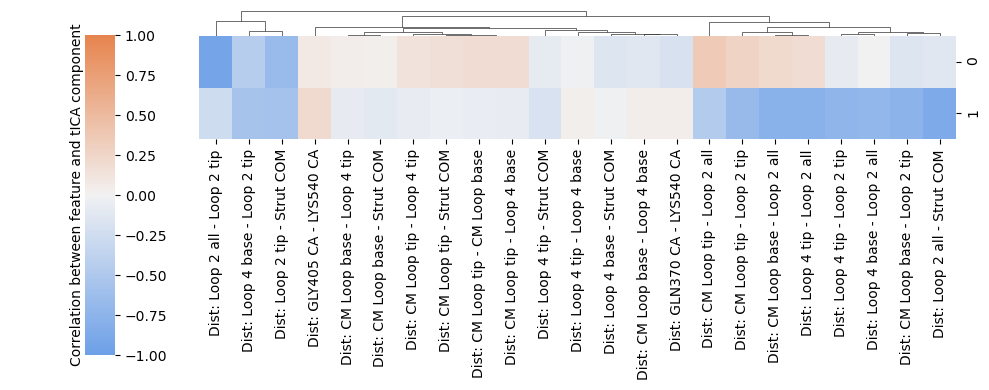

In [27]:
#### Create figure of feature correlation to tICA dimmension 

# Define color map 
blue_orang_cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)

# Use seaborn to create a cluster map of the feature correlation 
cluster_map = sns.clustermap(pd.DataFrame(np.array(tica.feature_TIC_correlation),
               index = formatted_list_name).T, 
               cmap=blue_orang_cmap, 
               metric = 'cityblock',
               row_cluster = False, 
               col_cluster = True, 
               vmax = 1, 
               vmin = -1, 
               figsize = (10,4), 
               cbar_pos= (0.09, 0.1, 0.03, 0.8), )

plt.xlabel('tICA Component')
plt.text(-0.5, -1.05, 'Correlation between feature and tICA component', rotation=90)

# plt.savefig('figures/tICA_correlation_clustermap.svg')
plt.show()


(-3.0, 3.0)

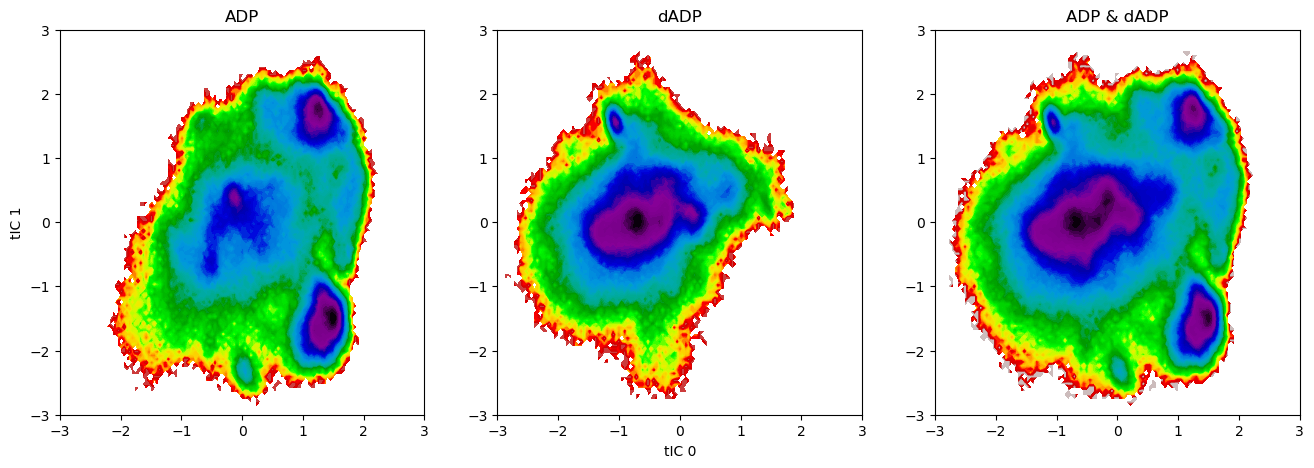

In [30]:
### Visualize the free energy surface 

# Create subplots
fig, ax = plt.subplots(1,3,figsize = (16,5))

# Plot the free energy surface of the ADP simulation data in tICA space
pyemma.plots.plot_free_energy(np.concatenate(tica_output[0:3])[:,0],
    np.concatenate(tica_output[0:3])[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[0], cbar = False)

ax[0].set_title('ADP')
ax[0].set_ylim([-3,3])
ax[0].set_xlim([-3,3])
ax[0].set_ylabel('tIC 1')

# Plot the free energy surface of the dADP simulation data in tICA space
pyemma.plots.plot_free_energy(np.concatenate(tica_output[3:6])[:,0],
    np.concatenate(tica_output[3:6])[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[1], cbar = False)

ax[1].set_title('dADP')
ax[1].set_ylim([-3,3])
ax[1].set_xlim([-3,3])
ax[1].set_xlabel('tIC 0')

# Plot the free energy surface of the combined ADP and dADP simulation data in tICA space
pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
    np.concatenate(tica_output)[:,1], 
    vmin = 0, 
    vmax = 7.2,
    ax = ax[2], cbar = False)

ax[2].set_title('ADP & dADP')
ax[2].set_ylim([-3,3])
ax[2].set_xlim([-3,3])

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

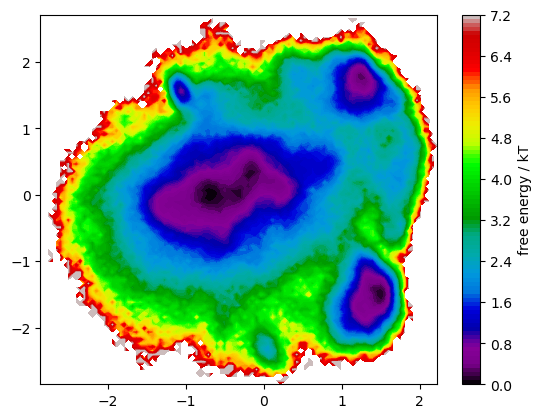

In [31]:
# Replot combined energy surface with scale 
pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
    np.concatenate(tica_output)[:,1])

## Approach for clustering and analysis. 
- Run tICA on the super set of all the features measured distances from the trajectory (section above)
- Select the two most prominent features from the selections (n_dim = 2) (section above)
- Select the tica output from only the ADP simulations and run k-means with k=500
- Then select the tica output from only the dADP simulations and again run k-means with k=500

**Note**: Even with a fixed seed, there may be variability between runs

In [32]:
# Combine the tICA output for ADP only 
adp_tica = [tica_output[0], tica_output[1],tica_output[2] ]
# Run k-means 500 clustering for ADP 
adp_clustering_results = pyemma.coordinates.cluster_kmeans(adp_tica, 
                                                       k=500,
                                                       max_iter = 500,
                                                       n_jobs = 24,
                                                       stride = 1,
                                                       # Fixed seed for reproducibility 
                                                       fixed_seed = 43) 


initialize kmeans++ centers:   0%|                                      | 0/500 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                | 0/500 [00:00<?, ?it/s]

In [33]:
# Combine the tICA output for dADP only 
dadp_tica = [tica_output[3], tica_output[4],tica_output[5] ]
# Run k-means 500 clustering for dADP 
dadp_clustering_results = pyemma.coordinates.cluster_kmeans(dadp_tica, 
                                                        k=500,
                                                        max_iter = 500, 
                                                        n_jobs = 24,
                                                        stride = 1,
                                                        # Fixed seed for reproducibility 
                                                        fixed_seed = 43)



initialize kmeans++ centers:   0%|                                      | 0/500 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                | 0/500 [00:00<?, ?it/s]

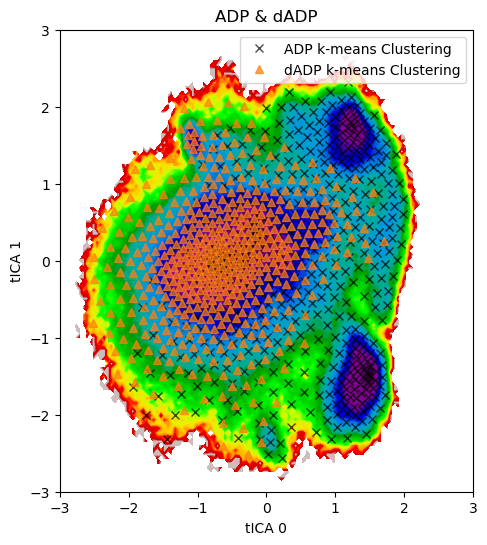

In [34]:
### Visualize cluster centers from ADP and dADP clustering results 

# Create figure 
fig, ax = plt.subplots(1,1,figsize = (16/3,6))

# Plot free energy of combined (ADP and dADP) tICA reduction 
pyemma.plots.plot_free_energy(np.concatenate(tica_output)[:,0],
np.concatenate(tica_output)[:,1], ax = ax, 
#cmap = 'viridis',
cbar = False)

# Plot ADP cluster centers (k = 500)
plt.plot(*adp_clustering_results.cluster_centers_[:,0:2].T,'kx', label = 'ADP k-means Clustering', alpha = 0.7)

# Plot dADP cluster centers (k = 500)
plt.plot(*dadp_clustering_results.cluster_centers_[:,0:2].T,'C1^', label = 'dADP k-means Clustering', alpha= 0.7)

plt.legend() # loc = (1.2, 0.4))
#plt.tight_layout()

ax.set_xlabel('tICA 0')
ax.set_ylabel('tICA 1')
plt.title('ADP & dADP')

plt.xlim([-3,3])
plt.ylim([-3,3])

plt.show()

In [35]:
# Calculate implied time scales accross a range of lag times
# to identify optimal lag time slection for ADP 
independent_its_adp = pyemma.msm.timescales_msm(adp_clustering_results.dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') 


getting output of KmeansClustering:   0%|                                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                            | 0/13 [00:00<?, ?it/s]

In [36]:
# Calculate implied time scales accross a range of lag times
# to identify optimal lag time slection for dADP 
independent_its_dadp = pyemma.msm.timescales_msm(dadp_clustering_results.dtrajs, lags=150, nits=15, n_jobs=24, errors='bayes') 


getting output of KmeansClustering:   0%|                                 | 0/3 [00:00<?, ?it/s]

estimating BayesianMSM:   0%|                                            | 0/13 [00:00<?, ?it/s]

(0.5512674027338345, 270017.20166412793)

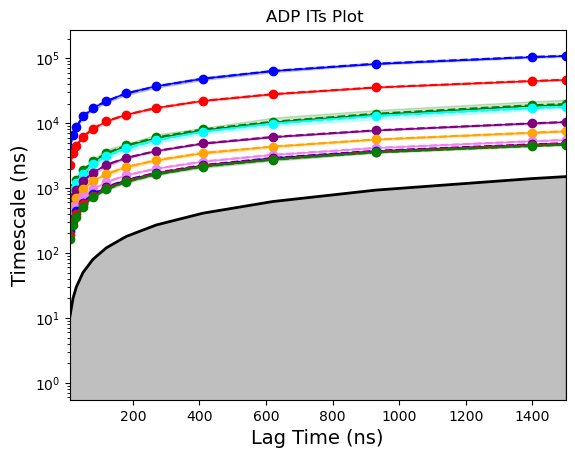

In [39]:
# Plot ITs for ADP MSM across a range of lag times 
pyemma.plots.plot_implied_timescales(independent_its_adp, units='ps', dt = 10, linewidth=1, nits = 10) #units can be ns if desired
plt.title('ADP ITs Plot ')
plt.xlabel('Lag Time (ns)', fontsize=14)
plt.ylabel('Timescale (ns)', fontsize=14)

plt.ylim(0.5512674027338345, 270017.20166412793)


(0.5512674027338345, 270017.20166412793)

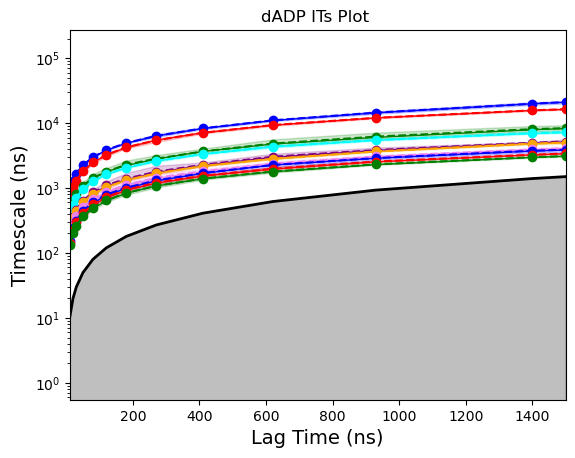

In [40]:
# Plot ITs for dADP MSM across a range of lag times 

pyemma.plots.plot_implied_timescales(independent_its_dadp, units='ps', dt = 10, linewidth=1, nits = 10) #units can be ns if desired
plt.title('dADP ITs Plot ')
plt.xlabel('Lag Time (ns)', fontsize=14)
plt.ylabel('Timescale (ns)', fontsize=14)
plt.ylim(0.5512674027338345, 270017.20166412793)


In [42]:
# Construct a 3 state model (3 state separation of ITs shown after construction)

n_metastable = 3

# Note: First time running, the model must be created 
# Subsequent iterations can load the model again 
if input("Do you want to load a model? (type 'load')") == 'load':
    print("Attempting to load model")
    adp_msm = pyemma.load('msm_datafiles/adp_msm.h5')
    ck_adp = pyemma.load('msm_datafiles/ck_adp.h5')
    
    dadp_msm = pyemma.load('msm_datafiles/dadp_msm.h5')
    ck_dadp = pyemma.load('msm_datafiles/ck_dadp.h5')
    print("Models loaded successfully")

else: 
    do_model = input("Preparing to re-calculated MSM models and CK tests, this is slow. Are you sure? (Enter 'run'): ")    
    if do_model == 'run':
        print("Running model calculation")
        adp_msm = pyemma.msm.bayesian_markov_model(adp_clustering_results.dtrajs, 90, reversible=True, dt_traj = '10 ps')

        ck_adp = adp_msm.cktest(n_metastable, memberships=None, conf=0.95, err_est=True, n_jobs=24, show_progress=True)

        adp_msm.save('msm_datafiles/adp_msm.h5', overwrite = True)

        ck_adp.save('msm_datafiles/ck_adp.h5', overwrite = True)

        dadp_msm = pyemma.msm.bayesian_markov_model(dadp_clustering_results.dtrajs, 90, reversible=True, dt_traj = '10 ps')

        ck_dadp = dadp_msm.cktest(n_metastable, memberships=None, conf=0.95, err_est=True, n_jobs=24, show_progress=True)

        dadp_msm.save('msm_datafiles/dadp_msm.h5', overwrite = True)

        ck_dadp.save('msm_datafiles/ck_dadp.h5', overwrite = True)



Do you want to load a model? (type 'load')no
Preparing to re-calculated MSM models and CK tests, this is slow. Are you sure? (Enter 'run'): run
Running model calculation


pyemma.msm.estimators.bayesian_msm.BayesianMSM[16]: compute stat. inefficiencies:   0%| | 0/4277

pyemma.msm.estimators.bayesian_msm.BayesianMSM[16]: Sampling MSMs:   0%| | 0/100 [00:00<?, ?it/s

estimating BayesianMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

pyemma.msm.estimators.bayesian_msm.BayesianMSM[18]: compute stat. inefficiencies:   0%| | 0/6535

pyemma.msm.estimators.bayesian_msm.BayesianMSM[18]: Sampling MSMs:   0%| | 0/100 [00:00<?, ?it/s

estimating BayesianMSM:   0%|                                             | 0/9 [00:00<?, ?it/s]

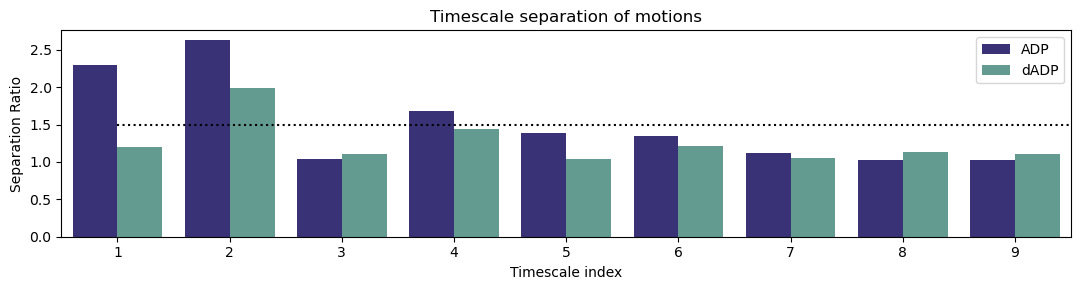

In [45]:
### Compare separation of implited timescales between movements 

# Create figure 
plt.figure(figsize = (10.91,3))
# Plot ratio of timescales to one another for ADP MSM
plt.bar(np.arange(9)-0.2,
        adp_msm.timescales()[0:10-1]/adp_msm.timescales()[1:10], width= 0.4, 
       align = 'center', 
       color = '#393276',
        label = 'ADP')

# Plot ratio of timescales to one another for dADP MSM
plt.bar(np.arange(9)+0.2,
        dadp_msm.timescales()[0:10-1]/dadp_msm.timescales()[1:10], width= 0.4, 
       align = 'center', 
       color = '#639B90', 
       label = 'dADP')

plt.plot(np.full(len(adp_msm.timescales()[:-1]/adp_msm.timescales()[1:]), 1.5), ':k')
plt.xlabel('Timescale index'); 
plt.ylabel('Separation Ratio')
plt.xlim(-0.5,8.5)
plt.title('Timescale separation of motions')

plt.xticks(np.arange(9), np.arange(9)+1)
plt.legend()
plt.tight_layout()


Based on the ratio being greater than 1.5 for the separation at index 2, we can identify that there should be 3 different metastable states for both ADP and dADP models. We can then use the Chapman-Kolmogorov test to validate the constructed models (see below). 

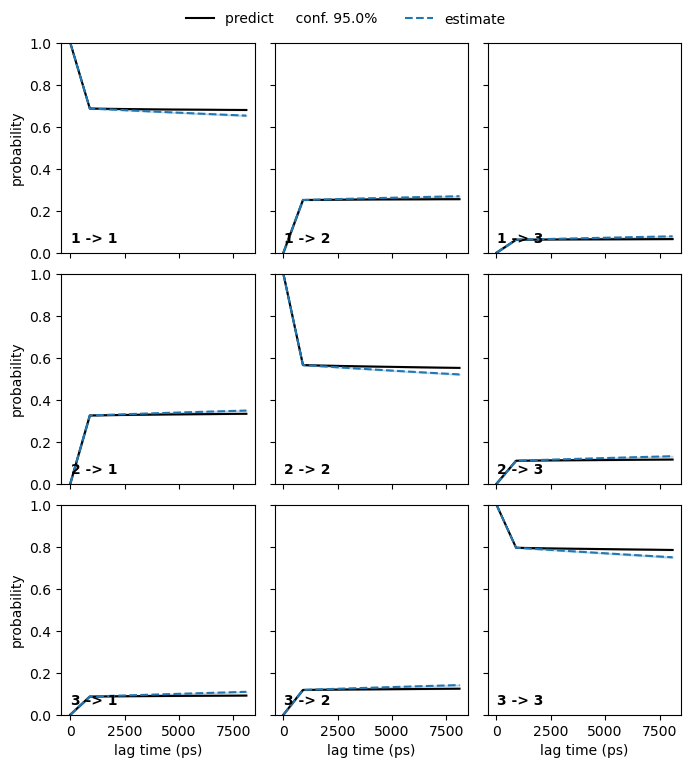

In [48]:
# CK Plot for ADP model 
pyemma.plots.plot_cktest(ck_adp, diag=False, figsize=(8,8), padding_top=0.05, y01=True, padding_between=0.1, dt=10, units='ps')
plt.show()

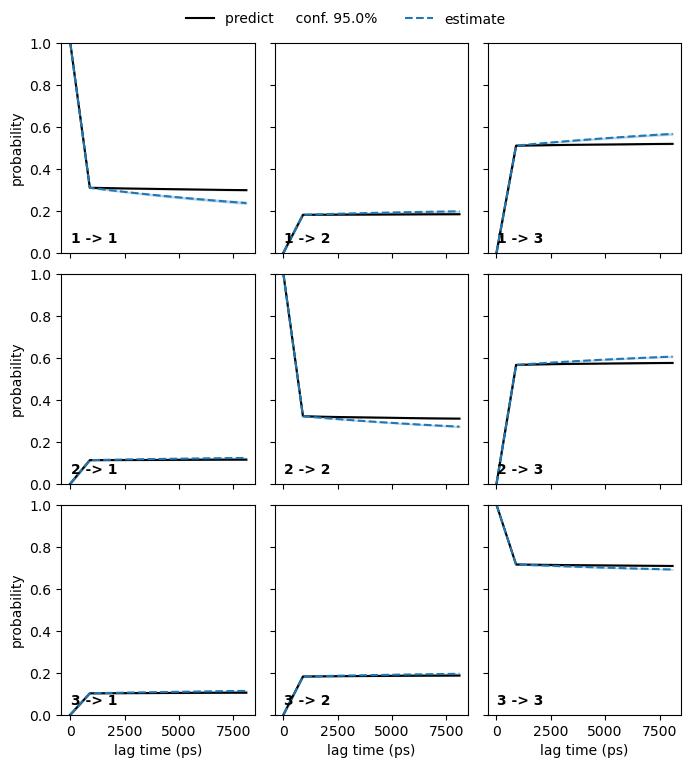

In [49]:
# CK Plot for dADP model 
pyemma.plots.plot_cktest(ck_dadp, diag=False, figsize=(8,8), padding_top=0.05, y01=True, padding_between=0.1, dt=10, units='ps')
plt.show()

## Network Visualization and Analysis
Given the constructed MSMs for the ADP and dADP myosin simulations we can begin to quantify differences in the MSM models, particularly when considering and visualizing using network methods. 

In [52]:
# Create full trajectory for ADP and dADP as single numpy arrays 
adp_full_traj = np.concatenate(adp_msm.dtrajs_full)
dadp_full_traj = np.concatenate(dadp_msm.dtrajs_full)


In [57]:
# Define helper function given a Markov state model 
# That will find the substate that has the greatest probaility 
# membership to the metastable states from the PCCA fuzzy clustering

def get_highest_memberships(markov_state_model, n_metastable):
    dists = markov_state_model.metastable_distributions
    assignments = markov_state_model.metastable_assignments
    highest = np.zeros(n_metastable, dtype = int)
    # Loop through metastable confs 
    for i in range(n_metastable):
        # Sorted from largest to smallest 
        sorted = dists[i].argsort()[::-1] 
        # Ensure it's actually assigned to the correct metastable state 
        within_state = assignments[sorted] == i
        highest[i] = sorted[within_state][0]
    return highest 



In [58]:
# Create a numpy array of the entire set of trajectories and metastable assignments
adp_metastable_traj = adp_msm.metastable_assignments[adp_full_traj]

# Find the highest probably member for each of the 3 metastable states
highest_membership_adp = get_highest_memberships(adp_msm, n_metastable= n_metastable)

# Find the coordinates in tIC space of the cluster center that is the coarse state center 
adp_coarse_state_centers = adp_clustering_results.clustercenters[highest_membership_adp]
# Returns a n_metastable x 2 array of center locations 

In [59]:
# Create a numpy array of the entire set of trajectories and metastable assignments
dadp_metastable_traj = dadp_msm.metastable_assignments[dadp_full_traj]

#Find the highest probably member for each of the 3 metastable states
highest_membership_dadp = get_highest_memberships(dadp_msm, n_metastable= n_metastable)

# Find the coordinates in tIC space of the cluster center that is the coarse state center 
dadp_coarse_state_centers = dadp_clustering_results.clustercenters[highest_membership_dadp]
# Returns a n_metastable x 2 array of center locations 

In [65]:
### Calculate mean first passage times (and inverses) between each state 
# Inverse MFPT used to indicate the flux (drawn arrows) between states 
# in network visualization

nstates = 3

# Carry out analysis for ADP 
adp_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        adp_mfpt[i, j] = adp_msm.mfpt(
            adp_msm.metastable_sets[i],
            adp_msm.metastable_sets[j])

adp_inverse_mfpt = np.zeros_like(adp_mfpt)
adp_nz = adp_mfpt.nonzero()
adp_inverse_mfpt[adp_nz] = 1.0 / adp_mfpt[adp_nz]

# Repeat for dADP 
nstates = 3

dadp_mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        dadp_mfpt[i, j] = dadp_msm.mfpt(
            dadp_msm.metastable_sets[i],
            dadp_msm.metastable_sets[j])

dadp_inverse_mfpt = np.zeros_like(dadp_mfpt)
dadp_nz = dadp_mfpt.nonzero()
dadp_inverse_mfpt[dadp_nz] = 1.0 / dadp_mfpt[dadp_nz]

adp_stable_counts= np.zeros(3)

for i in range(3):
    adp_stable_counts[i] = np.sum(adp_metastable_traj==i)
    
adp_stable_counts /= len(adp_stable_counts)


dadp_stable_counts= np.zeros(3)

for i in range(3):
    dadp_stable_counts[i] = np.sum(dadp_metastable_traj==i)
    
dadp_stable_counts /= len(dadp_stable_counts)


In [66]:
### Definite plotting colors 

from matplotlib.colors import ListedColormap

# List of HEX colors for ADP 
ADP_colors = ['#8063FF', '#332288', '#281E50']
# List of HEX colors for dADP 
dADP_colors = ['#58E9D3', '#44AA99', '#22564E']

# Create a ListedColormap
adp_custom_cmap = ListedColormap(ADP_colors)
dadp_custom_cmap = ListedColormap(dADP_colors)


In [68]:
# Create pandas dataframe for easier manipulation with seaborn visualization 
adp_state_df = pd.DataFrame(np.concatenate(adp_tica), columns = ['tic_0','tic_1'])
adp_state_df['state'] = adp_metastable_traj

dadp_state_df = pd.DataFrame(np.concatenate(dadp_tica), columns = ['tic_0','tic_1'])
dadp_state_df['state'] = dadp_metastable_traj

(-3.0, 3.0)

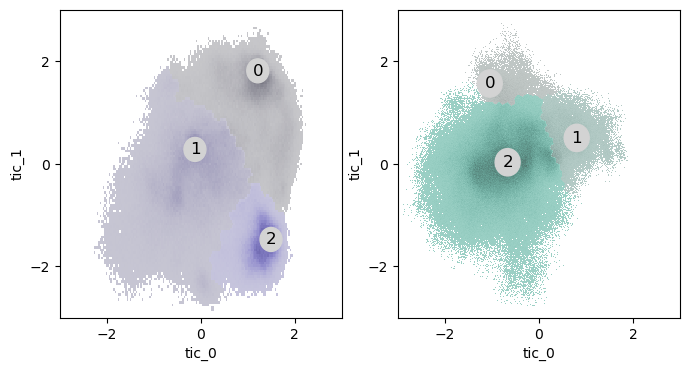

In [70]:
# Use a 2D histograph to visaulize the state space for the 
# Different metastable conditions 

# Note: seaborn histogram is much, much faster than seaborn KDE plot 

fig, ax = plt.subplots(1,2,figsize=(8, 4))

sns.histplot(data = adp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#393276", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[0],
            legend = False
           )

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax[0])

ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])

ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

sns.histplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[1],
            legend = False
           )

# Draw network and arrows 
# Note, arrows are stuck below the sns histrogram 
# Must be edited in a vector graphic tool to bring to surface 
pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3,
    arrow_curvature = 2,
    ax=ax[1])

sns.histplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           #common_grid = True,
           # common_norm = True,
            ax = ax[1],
            legend = False,
           zorder = float('-inf'))



ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])

ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

# plt.savefig('figures/adp_and_dadp_contour_statemap_network.svg')

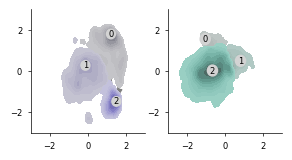

In [71]:
# Use a 2D KDE plot to visaulize the state space for the 
# Different metastable conditions 

# Note: This is very slow and the seaborn histogram is much, much
# faster than seaborn KDE plot (see above cell)

fig, ax = plt.subplots(1,2,figsize=(3.25, 1.6))


sns.kdeplot(data = adp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#393276", as_cmap=True),
           common_grid = True,
            common_norm = True,
            ax = ax[0],
            legend = False
           )

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12/2,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3/3,
    arrow_curvature = 2,
    ax=ax[0])

ax[0].set_xticks([-2,0,2])
ax[0].set_yticks([-2,0,2])

ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

sns.kdeplot(data = dadp_state_df, x = 'tic_0',y = 'tic_1', hue = 'state',
            fill = True,
            palette= sns.light_palette("#639B90", as_cmap=True),
           common_grid = True,
            common_norm = True,
            ax = ax[1],
            legend = False
           )


pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12/2,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3/3,
    arrow_curvature = 2,
    ax=ax[1])

ax[1].set_xticks([-2,0,2])
ax[1].set_yticks([-2,0,2])

ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

# Set the tick parameters
for i in range(2):
    ax[i].tick_params(width=0.5, length = 2.5)

    # Set the linewidth for the spines
    for spine in ax[i].spines.values():
        spine.set_linewidth(0.5)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    plt.sca(ax[i])
    plt.xticks(fontsize = 6)
    plt.yticks(fontsize = 6)

    #ax[i].set_position([left, bottom, width, height])

# plt.savefig('figures/adp_and_dadp_contour_statemap_network.svg')
# Note, again arrows are in a layer below KDE plot 

Text(0.5, 1.0, 'ATP State Space Visualizaton')

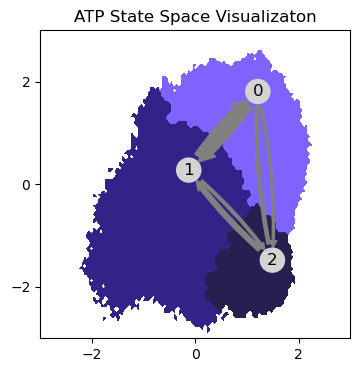

In [73]:
# Non-countour state space visualization 

fig, ax = plt.subplots(figsize = (4,4))
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(adp_tica).T, adp_metastable_traj, ax=ax, zorder=-1, cmap = adp_custom_cmap, cbar = False)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    adp_inverse_mfpt,
    pos=adp_coarse_state_centers,
    figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=adp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    ax=ax)

ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.title('ATP State Space Visualizaton')


Text(0.5, 1.0, 'dATP State Space Visualization')

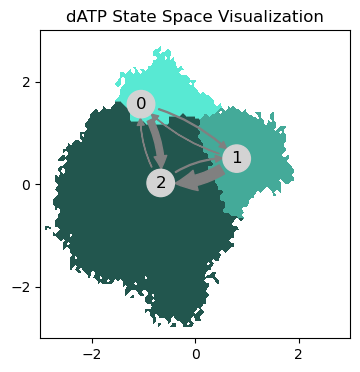

In [74]:
# Non-countour state space visualization 

fig, ax = plt.subplots(figsize=(4, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *np.concatenate(dadp_tica).T, dadp_metastable_traj, ax=ax, zorder=-1, cbar = False, cmap = dadp_custom_cmap)
# misc['cbar'].set_ticklabels(range(0, nstates + 0))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    dadp_inverse_mfpt,
    pos=dadp_coarse_state_centers,
    #figpadding=0,
    #arrow_label_format='%.0f ps',
    arrow_label_format='',
    #state_sizes = np.array([0.1,5,10]),
    arrow_labels=dadp_mfpt,
    size=12,
    show_frame=True,
    state_colors = '#D3D3D3',
    arrow_scale = 1.3,
    arrow_curvature = 2,
    ax=ax)

ax.set_xticks([-2,0,2])
ax.set_yticks([-2,0,2])

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.title('dATP State Space Visualization')

/tmp/ipykernel_68786/1924666557.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


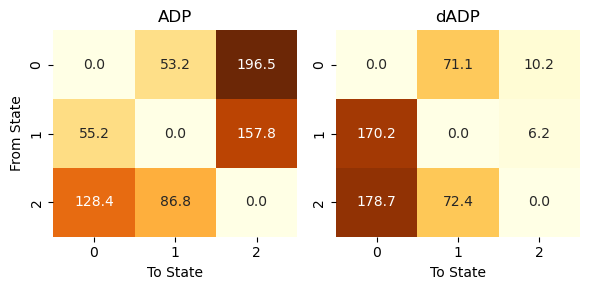

In [76]:
# Mean first passage time heatmap analysis

fig, ax = plt.subplots(1,2,figsize = (6,3))

sns.heatmap(adp_mfpt/1000, ax = ax[0], 
            cbar = False, 
            vmin = 0,
            vmax = 200,
            annot= True, 
            cmap = 'YlOrBr',fmt=".1f")

sns.heatmap(dadp_mfpt/1000, ax = ax[1], 
            cbar = False,
            vmin = 0, 
            vmax = 200,
            annot= True,
            cmap = 'YlOrBr',fmt=".1f")
ax[0].set_ylabel('From State') 
ax[0].set_xlabel('To State')
ax[1].set_xlabel('To State')

ax[0].set_title('ADP')
ax[1].set_title('dADP')
#fig.text(0.5,1.0,'Mean first Passage Time (ns)', ha = 'center', fontsize = 14)
plt.tight_layout()
fig.show()


Note: Due to the random sampling, we have saved the selection of sampled frames from the iteration that was used in the Brownian dynamics simulations. This data is stored in the files `adp_sampled_frame_data_bd.pkl` and `dadp_sampled_frame_data_bd.pkl` file. 

By default, the cells below will not load this data, and instead will try to load a newly generated file specific to the most recent run. Once sampled, they will then be loaded by default. 

In [184]:

adp_samples_file = "msm_datafiles/adp_sampled_frame_data.pkl"

# Uncomment the line below to load in the file that was used in the manuscript
# adp_samples_file = "msm_datafiles/adp_sampled_frame_data_bd.pkl"

try:
    f = open(adp_samples_file, 'rb')
    adp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(adp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(adp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print("Unable to load file. ")
    print("Sampling from MSM. ")
    adp_samples = adp_msm.sample_by_distributions(adp_msm.metastable_distributions,15)
    f = open(adp_samples_file,'wb')
    pickle.dump(adp_samples, f)
    f.close()
    print('Saved to {}'.format(adp_samples_file))

Unable to load file. 
Sampling from MSM. 
Saved to msm_datafiles/adp_sampled_frame_data.pkl


In [185]:

dadp_samples_file = "msm_datafiles/dadp_sampled_frame_data.pkl"

# Uncomment the line below to load in the file that was used in the manuscript
# adp_samples_file = "msm_datafiles/dadp_sampled_frame_data_bd.pkl"

try:
    f = open(dadp_samples_file, 'rb')
    dadp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(dadp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(dadp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print("Unable to load file. ")
    print("Sampling from MSM. ")
    dadp_samples = dadp_msm.sample_by_distributions(dadp_msm.metastable_distributions,15)
    f = open(dadp_samples_file,'wb')
    pickle.dump(dadp_samples, f)
    f.close()
    print('Saved to {}'.format(dadp_samples_file))

Unable to load file. 
Sampling from MSM. 
Saved to msm_datafiles/dadp_sampled_frame_data.pkl


#### Generate Structures using CPPTRAJ
The follow cells are used to generate a file that can quickly extract the sampled states using cpptraj, and extract their VDW radii and charges. These structures can then be used for the Brownian dynaimcs. 

Just copy the below printed file into a new text file (i.e. `extract_frames.in`) which can then be read with CPPTRAJ. Note, you will likely need to change the file path variable. 

Also note that the files generated by CPPTRAJ will be PDB files by filename convention, but actually are PQR files because they include the atomic radii and charges. 

In [74]:
file_path = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories'
top_file = '1qvi_adp_strip.prmtop'
for k in range(3):
    print("# Metastable states: {}".format(k))
    print('parm {}/{}'.format(file_path, top_file))
    for traj_n, frame_n in adp_samples[k]:
        #f traj_n == k:
        print("trajin {}/1qvi_adp_{}_2us_10ps.nc {} {}".format(file_path, traj_n+1,frame_n,frame_n))
    
    print('align :1-760@CA')
    print('strip :811-813,970 parmout 1qvi_protein_test.parm7 ')
    print()
    #print('trajout test_metastatble_{}.pdb\n'.format(k))
    # trajout stripped_cluster.pdb pdb vdw multi nobox noter
    print('for i=1;i<=15;i++\n\ttrajout metastable_{}_$i.pdb pdb vdw nobox noter start $i stop $i \ndone\n'.format(k))
    print('run')
    print('clear all')
    print()

# Metastable states: 0
parm /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_strip.prmtop
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 73988 73988
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 132618 132618
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 16675 16675
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_3_2us_10ps.nc 22620 22620
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_2_2us_10ps.nc 114782 114782
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 152143 152143
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc 16257 16257
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_adp_1_2us_10ps.nc

In [75]:
file_path = '/media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories'
top_file = '1qvi_dadp_strip.prmtop'
for k in range(3):
    print("# Metastable states: {}".format(k))
    print('parm {}/{}'.format(file_path, top_file))
    for traj_n, frame_n in dadp_samples[k]:
        #f traj_n == k:
        print("trajin {}/1qvi_dadp_{}_2us_10ps.nc {} {}".format(file_path, traj_n+1,frame_n,frame_n))
    
    print('align :1-760@CA')
    print('strip :811-813,970 parmout 1qvi_protein_test.parm7 ')
    print()
    #print('trajout test_metastatble_{}.pdb\n'.format(k))
    # trajout stripped_cluster.pdb pdb vdw multi nobox noter
    print('for i=1;i<=15;i++\n\ttrajout metastable_{}_$i.pdb pdb vdw nobox noter start $i stop $i \ndone\n'.format(k))
    print('run')
    print('clear all')
    print()

# Metastable states: 0
parm /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_strip.prmtop
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_1_2us_10ps.nc 190088 190088
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 108489 108489
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 93014 93014
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 136159 136159
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_2_2us_10ps.nc 180126 180126
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 145738 145738
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dadp_3_2us_10ps.nc 155887 155887
trajin /media/marcus/OS/Users/marcus/Documents/myosin_dynamics/trajectories/1qvi_dad